# Análisis de prueba A/B: Sistema de Recomendaciones

## 1. Objetivos del estudio

### 🎯 Propósito general
Evaluar si la introducción de un **nuevo sistema de recomendaciones** en la tienda en línea mejora las tasas de conversión en comparación con el sistema actual.

---

### 🧪 Contexto del experimento

| Elemento                     | Descripción                                               |
|-----------------------------|-----------------------------------------------------------|
| **Nombre del experimento**  | `recommender_system_test`                                 |
| **Grupo A (control)**       | Sistema de recomendaciones actual                         |
| **Grupo B (experimental)**  | Nuevo sistema de recomendaciones                          |
| **Audiencia**               | 15% de los nuevos usuarios de la región UE                |
| **Período de inscripción**  | Del 7 al 21 de diciembre de 2020                          |
| **Fin del período de prueba** | 1 de enero de 2021                                     |
| **Duración de análisis por usuario** | 14 días desde la fecha de inscripción        |

---

### 📌 Objetivo específico
Determinar si los usuarios del **grupo B** presentan una **mejor conversión** en las siguientes etapas del embudo de ventas:

1. `product_page` → vista de una página de producto  
2. `product_cart` → agregó producto al carrito  
3. `purchase` → realizó una compra

---

### 📈 Criterio de éxito
Se espera que el grupo B tenga una **tasa de conversión al menos un 10% mayor** que el grupo A en **cada etapa** del embudo.

---

### 📊 Hipótesis estadísticas

Para cada evento del embudo:

| Etapa del embudo | Hipótesis nula (H₀)     | Hipótesis alternativa (H₁)          |
|------------------|--------------------------|--------------------------------------|
| `product_page`   | p_B ≤ p_A                | p_B ≥ p_A × 1.10                     |
| `product_cart`   | p_B ≤ p_A                | p_B ≥ p_A × 1.10                     |
| `purchase`       | p_B ≤ p_A                | p_B ≥ p_A × 1.10                     |

Donde `p_A` y `p_B` representan la tasa de conversión del grupo A (control) y del grupo B (experimental), respectivamente.

---

### 🔖 Nota importante
Para cumplir con los criterios del experimento, **solo se deben considerar los eventos que ocurran dentro de los 14 días posteriores a la inscripción de cada usuario**.


## 2. Carga y preprocesamiento de datos

### 📦 Importación de librerías

Importamos las librerías necesarias para análisis de datos, visualización y pruebas estadísticas. Usaremos `pandas` para manipulación de datos, `seaborn` y `matplotlib` para visualizaciones, y `statsmodels` y `scipy` para pruebas A/B.


In [1]:
#importar librerias 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

### 📥 Carga de los datasets

Cargamos los cuatro archivos CSV proporcionados en el proyecto:

- `df_marketing_events`: calendario de campañas de marketing.
- `df_new_users`: usuarios registrados.
- `df_events`: eventos realizados por los usuarios.
- `df_participants`: usuarios asignados a grupos del experimento.

Estas tablas nos permitirán validar la prueba A/B y analizar la conversión.


In [2]:
#Cargar 
df_marketing_events = pd.read_csv('ab_project_marketing_events_us.csv')
df_new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
df_events= pd.read_csv('final_ab_events_upd_us.csv')
df_participants = pd.read_csv('final_ab_participants_upd_us.csv')

### 🧾 Revisión inicial de tipos de datos y estructura

Inspeccionamos la estructura de cada dataset (`.info()` y `.head()`) para verificar:

- Cantidad de filas y columnas
- Tipos de datos (para detectar fechas mal tipadas como `object`)
- Ausencia de valores nulos en columnas clave


In [3]:
df_marketing_events.info()
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [4]:
df_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
df_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
df_events.info()
df_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [7]:
df_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
df_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


### 🕒 Conversión de columnas de fecha

Convertimos las columnas de fecha a tipo `datetime` para poder realizar comparaciones, filtros y cálculos de duración durante el análisis posterior.


In [9]:
# Convertir columnas de fecha
df_marketing_events['start_dt'] = pd.to_datetime(df_marketing_events['start_dt'])
df_marketing_events['finish_dt'] = pd.to_datetime(df_marketing_events['finish_dt'])

df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])
df_events['event_dt'] = pd.to_datetime(df_events['event_dt'])

### 🔁 Verificación de duplicados

Revisamos si hay filas duplicadas en los datasets principales. Esto es importante para evitar sesgos en el análisis, especialmente en `df_participants`, donde cada usuario debe aparecer una única vez.


In [10]:
# Revisar duplicados
print("Duplicados:")
print("marketing_events:", df_marketing_events.duplicated().sum())
print("new_users:", df_new_users.duplicated().sum())
print("events:", df_events.duplicated().sum())
print("participants:", df_participants.duplicated().sum())

Duplicados:
marketing_events: 0
new_users: 0
events: 0
participants: 0


### 🔎 Revisión de valores nulos

Verificamos si existen valores faltantes en los datasets. Esto es importante para:

- Asegurar la integridad de los datos antes del análisis.
- Detectar columnas como `details`, donde los nulos son esperados (por ejemplo, eventos que no son compras).


In [11]:
# Revisar valores nulos
print("\nValores nulos:")
print("marketing_events:\n", df_marketing_events.isna().sum())
print("new_users:\n", df_new_users.isna().sum())
print("events:\n", df_events.isna().sum())
print("participants:\n", df_participants.isna().sum())


Valores nulos:
marketing_events:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
new_users:
 user_id       0
first_date    0
region        0
device        0
dtype: int64
events:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
participants:
 user_id    0
group      0
ab_test    0
dtype: int64


### 📆 Rango de fechas y regiones en usuarios nuevos

Validamos que las fechas de inscripción de los usuarios estén dentro del período oficial del experimento (del 7 al 21 de diciembre de 2020).  
También revisamos las regiones de los usuarios para asegurarnos de quedarnos únicamente con la región **EU**, que es la única incluida en el experimento.


In [12]:
# Rango de fechas en los nuevos usuarios
print("Fechas de inscripción:")
print(df_new_users['first_date'].min(), "→", df_new_users['first_date'].max())

# Revisar valores únicos en región
print("\nRegiones:")
print(df_new_users['region'].value_counts())


Fechas de inscripción:
2020-12-07 00:00:00 → 2020-12-23 00:00:00

Regiones:
region
EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: count, dtype: int64


### 🧹 Filtrado de usuarios válidos por fecha y región

Filtramos `df_new_users` para incluir solo usuarios:

- Registrados entre el **7 y el 21 de diciembre de 2020**.
- De la región **UE**.

Luego actualizamos `df_participants` para que contenga únicamente los `user_id` válidos según ese filtro.


In [13]:
# Primero filtramos df_new_users por fecha y región:
df_new_users = df_new_users[
    (df_new_users['first_date'] >= '2020-12-07') &
    (df_new_users['first_date'] <= '2020-12-21') &
    (df_new_users['region'] == 'EU')
]

# filtramos df_participants para que solo queden los user_id válidos
usuarios_validos = df_new_users['user_id'].unique()
df_participants = df_participants[df_participants['user_id'].isin(usuarios_validos)]


### ⚠️ Detección y eliminación de usuarios duplicados en `df_participants`

Cada usuario debe estar asignado a un solo grupo A o B. Identificamos usuarios que aparecen más de una vez en el experimento (posiblemente en ambos grupos), lo cual invalida su participación.

Procedemos a eliminar estos usuarios duplicados de todos los datasets para mantener la integridad de la prueba A/B.


In [14]:
duplicados = df_participants.duplicated(subset='user_id', keep=False)
usuarios_duplicados = df_participants[duplicados]
print("Número de usuarios duplicados:", usuarios_duplicados['user_id'].nunique())
print(usuarios_duplicados.head())


Número de usuarios duplicados: 887
             user_id group                  ab_test
2   DABC14FDDFADD29E     A  recommender_system_test
3   04988C5DF189632E     A  recommender_system_test
8   B3A2485649E4A012     A  recommender_system_test
15  EAFB9027A27D510C     B  recommender_system_test
17  5D5E6EE92AF6E9E0     B  recommender_system_test


In [15]:
# Identificar todos los user_id duplicados 
usuarios_problematicos = df_participants[df_participants.duplicated('user_id', keep=False)]['user_id'].unique()

# Eliminar esos usuarios de df_participants
df_participants = df_participants[~df_participants['user_id'].isin(usuarios_problematicos)]

In [16]:
df_events = df_events[~df_events['user_id'].isin(usuarios_problematicos)]
df_new_users = df_new_users[~df_new_users['user_id'].isin(usuarios_problematicos)]

### ✅ Verificación final del preprocesamiento

Mostramos el tamaño de los datasets tras la limpieza. Ahora contamos con:

- Solo usuarios únicos
- Fechas y regiones válidas
- Datos consistentes entre las tablas

Estamos listos para pasar al análisis exploratorio de datos (EDA).


In [17]:
print("Participantes finales:", df_participants.shape)
print("Eventos finales:", df_events.shape)
print("Usuarios nuevos finales:", df_new_users.shape)

Participantes finales: (11555, 3)
Eventos finales: (418046, 4)
Usuarios nuevos finales: (38579, 4)


## 3. Análisis exploratorio (EDA)

### 🔍 Conteo de usuarios por grupo

Contamos la cantidad de usuarios asignados a cada grupo del experimento (`A` y `B`). Esto nos permite confirmar que la asignación fue equilibrada y que no hubo sesgos al momento de dividir a los usuarios.

In [18]:
# Conteo de usuarios por grupo
df_participants['group'].value_counts()

group
A    6461
B    5094
Name: count, dtype: int64

### 🌍 Distribución geográfica de los usuarios

Verificamos la distribución por región de los usuarios nuevos. En este caso, todos los usuarios provienen de la región `EU`, lo que indica que el análisis se enfoca únicamente en ese mercado.

In [19]:
df_new_users['region'].value_counts()

region
EU    38579
Name: count, dtype: int64

### 📈 Distribución de eventos por usuario

Graficamos la cantidad de eventos realizados por usuario. Esto nos ayuda a entender el comportamiento general y detectar la presencia de usuarios muy activos (outliers), que podrían distorsionar el análisis si no se ajusta correctamente.

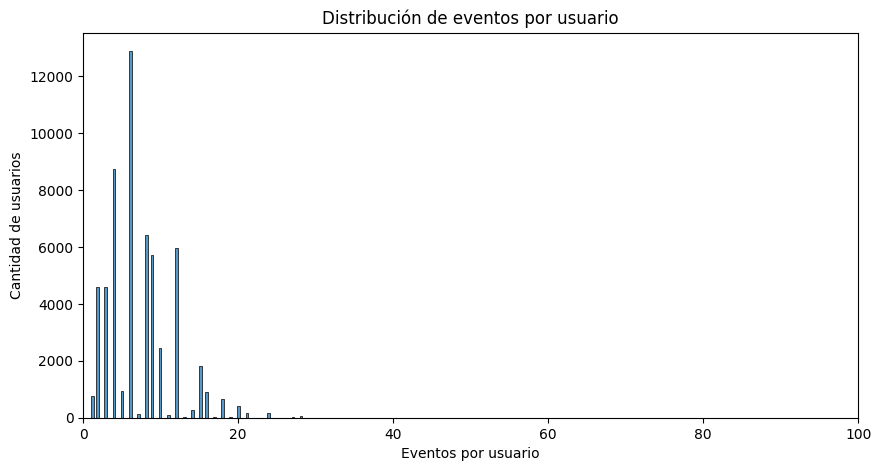

In [20]:
# Contar número de eventos por usuario
eventos_por_usuario = df_events['user_id'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(eventos_por_usuario, bins=100, kde=False)
plt.title('Distribución de eventos por usuario')
plt.xlabel('Eventos por usuario')
plt.ylabel('Cantidad de usuarios')
plt.xlim(0, 100)  # outliers extremos y ver mejor el cuerpo principal
plt.show()

### 📅 Cantidad total de eventos por día

Visualizamos el número total de eventos registrados por día para identificar tendencias a lo largo del tiempo. Se observa un pico notable antes del 25 de diciembre, probablemente influenciado por las festividades navideñas.

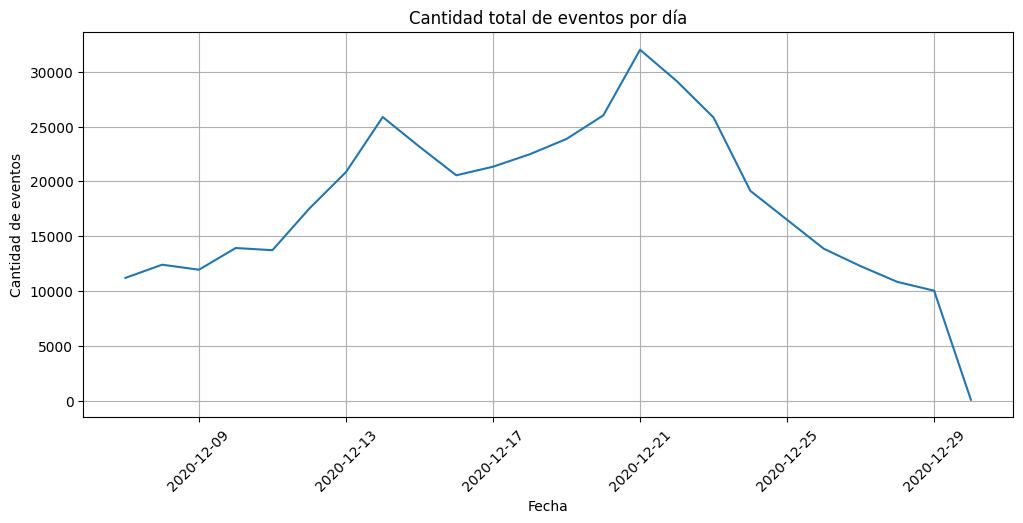

In [21]:
# Eventos por día
eventos_diarios = df_events.groupby(df_events['event_dt'].dt.date)['event_name'].count()

plt.figure(figsize=(12, 5))
eventos_diarios.plot()
plt.title('Cantidad total de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de eventos')
plt.xticks(rotation=45)
plt.grid()
plt.show()

### 🎯 Campañas activas durante diciembre

Revisamos las campañas de marketing activas en diciembre, como la "Christmas&New Year Promo", que pudo haber impactado el comportamiento de los usuarios durante el experimento. Es clave tenerlo en cuenta al interpretar los resultados.

In [22]:
# Mostrar campañas activas durante diciembre
campañas_diciembre = df_marketing_events[
    (df_marketing_events['start_dt'].dt.month == 12) &
    (df_marketing_events['start_dt'].dt.year == 2020)
]

campañas_diciembre

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


### ✅ Verificación de duplicados en participantes

Nos aseguramos de que no haya usuarios duplicados en la tabla de participantes. Confirmamos que cada `user_id` aparece solo una vez, garantizando que los grupos del experimento están correctamente definidos.

In [23]:
df_participants['user_id'].duplicated().sum()

np.int64(0)

## 4. Análisis del embudo de conversión

### 🧩 Preparación de usuarios para el análisis del embudo

Unimos la información de los participantes con sus fechas de inscripción para poder calcular con precisión los eventos que ocurrieron dentro de los **14 días posteriores al registro**, como exige el experimento.

In [24]:
# Unir para obtener la fecha de inscripción de cada participante
df_users = df_participants.merge(df_new_users[['user_id', 'first_date']], on='user_id', how='left')

### ⏳ Filtrado de eventos dentro del período de análisis

Para cada usuario, consideramos únicamente los eventos que ocurrieron durante los primeros **14 días desde su inscripción**.  
Esto garantiza que analizamos el comportamiento en el mismo marco temporal para todos los participantes.

In [25]:
# Unir eventos con la fecha de inscripción
df_events_filtrados = df_events.merge(df_users[['user_id', 'first_date']], on='user_id', how='inner')

# Calcular días desde la inscripción
df_events_filtrados['days_since_signup'] = (df_events_filtrados['event_dt'] - df_events_filtrados['first_date']).dt.days

# Filtrar solo los eventos dentro de los primeros 14 días
df_events_filtrados = df_events_filtrados[df_events_filtrados['days_since_signup'] < 14]

### 🔄 Construcción del embudo de conversión por usuario

Creamos una tabla donde cada fila representa un usuario y cada columna indica si completó o no cada etapa del embudo:

- `viewed_product_page`: vio al menos un producto
- `added_to_cart`: agregó al carrito
- `made_purchase`: realizó una compra

Esto nos permitirá comparar tasas de conversión entre los grupos A y B.

In [26]:
# Crear columnas binarias por usuario
embudo = df_events_filtrados.pivot_table(
    index='user_id',
    columns='event_name',
    values='event_dt',
    aggfunc='min'  
).notna().astype(int).reset_index()

# Renombrar columnas para que sean más claras
embudo.columns.name = None
embudo = embudo.rename(columns={
    'product_page': 'viewed_product_page',
    'product_cart': 'added_to_cart',
    'purchase': 'made_purchase'
})

In [27]:
# Unir con los grupos
embudo = embudo.merge(df_users[['user_id', 'group']], on='user_id', how='left')

In [28]:
embudo.head()

,user_id,login,added_to_cart,viewed_product_page,made_purchase,group
0,0002CE61FF2C4011,1,1,1,0,A
1,0010A1C096941592,1,0,1,1,A
2,001E72F50D1C48FA,1,0,1,0,B
3,002412F1EB3F6E38,1,0,1,0,A
4,002540BE89C930FB,1,1,1,0,A


### 📊 Cálculo de tasas de conversión por grupo

Calculamos el porcentaje de usuarios que completaron cada etapa del embudo en cada grupo (A y B).  
Estas tasas nos dan una primera visión comparativa antes de aplicar pruebas estadísticas.

In [29]:
# Agrupar por grupo y calcular tasas de conversión
conversiones = embudo.groupby('group')[['viewed_product_page', 'added_to_cart', 'made_purchase']].mean().round(4) * 100

# Mostrar como porcentaje
conversiones

,viewed_product_page,added_to_cart,made_purchase
group,,,
A,66.49,32.01,34.44
B,64.40,33.38,32.79


## 5. Evaluación de la prueba A/B

In [30]:
# Total de usuarios por grupo
total_por_grupo = embudo['group'].value_counts()

# Contar usuarios que completaron cada etapa por grupo
conversion_counts = embudo.groupby('group')[['viewed_product_page', 'added_to_cart', 'made_purchase']].sum()

### 🧪 Prueba estadística 

Aplicamos una prueba z para comparar si las diferencias en tasas de conversión entre los grupos A y B son **estadísticamente significativas**.  
Esto nos permite determinar si los cambios observados podrían deberse al azar o reflejan una mejora real.

In [31]:
# Función para aplicar test Z entre A y B en cada etapa
def test_z_por_etapa(etapa):
    successes = [conversion_counts.loc['A', etapa], conversion_counts.loc['B', etapa]]
    nobs = [total_por_grupo['A'], total_por_grupo['B']]
    stat, pval = proportions_ztest(count=successes, nobs=nobs, alternative='larger')
    return round(stat, 4), round(pval, 4)

# Aplicar a cada etapa
for etapa in ['viewed_product_page', 'added_to_cart', 'made_purchase']:
    stat, pval = test_z_por_etapa(etapa)
    print(f"Etapa: {etapa}")
    print(f"  Estadístico Z: {stat}")
    print(f"  p-valor: {pval}")
    print("-" * 30)

Etapa: viewed_product_page
  Estadístico Z: 2.3405
  p-valor: 0.0096
------------------------------
Etapa: added_to_cart
  Estadístico Z: -1.5558
  p-valor: 0.9401
------------------------------
Etapa: made_purchase
  Estadístico Z: 1.8656
  p-valor: 0.0311
------------------------------


## 6. Conclusiones

### 🎯 Objetivo del experimento
El objetivo de la prueba A/B `recommender_system_test` era evaluar si un nuevo sistema de recomendaciones mejora la conversión en el embudo de ventas dentro de los 14 días posteriores al registro de los usuarios.

Se esperaba un aumento mínimo del **10%** en las siguientes etapas:

- Vista de producto (`product_page`)
- Agregado al carrito (`product_cart`)
- Compra (`purchase`)

---

### 📊 Resultados obtenidos

| Etapa                | Grupo A (%) | Grupo B (%) | Diferencia | p-valor | ¿Significativo? |
|----------------------|-------------|-------------|------------|---------|------------------|
| `product_page`       | 66.49       | 64.40       | -2.09      | 0.0096  | ✅ Sí            |
| `product_cart`       | 32.01       | 33.38       | +1.37      | 0.9401  | ❌ No            |
| `purchase`           | 34.44       | 32.79       | -1.65      | 0.0311  | ✅ Sí (en contra) |

> 🔍 *Nota: Aunque las diferencias en `product_page` y `purchase` fueron estadísticamente significativas, ninguna alcanzó el 10% de mejora requerido. Además, en `purchase` el grupo B tuvo **peor rendimiento** que A.*

---

### ⚖️ Interpretación

- ✅ El grupo B tuvo una **mejor tasa de visualización de productos**, pero **no cumplió con el aumento del 10% requerido**.
- ❌ En la etapa de agregado al carrito, **no hubo diferencias significativas** entre los grupos.
- ⚠️ En la etapa más crítica (`purchase`), el **grupo A superó a B**, lo que **podría indicar un efecto negativo del nuevo sistema**.

---

### 🧠 Conclusión general

La implementación del nuevo sistema **no logró mejorar el embudo de conversión** de manera significativa ni alcanzar los objetivos planteados.

---

### 💡 Recomendaciones

- **No implementar el nuevo sistema de recomendaciones por ahora**. Su efecto en la etapa de compra es preocupante.
- Revisar el diseño y lógica del nuevo sistema para entender por qué pudo haber afectado negativamente la conversión.
- Considerar una **nueva iteración del experimento** con un rediseño del sistema y una mejor distribución de grupos.
- Si se insiste en implementarlo, hacerlo en un entorno controlado o con usuarios menos sensibles (por ejemplo, nuevos visitantes, no usuarios recurrentes).

---

### 📌 Limitaciones

- Ligera diferencia en tamaño entre grupos A y B.
- Actividad de los usuarios más recientes coincidió con campañas navideñas, lo cual podría haber influido en su comportamiento.
- El experimento solo incluyó usuarios de la región UE.

---

### 🏁 Veredicto final

❌ **El experimento no valida la implementación del nuevo sistema de recomendaciones.**  
📊 **Los datos indican que no mejora la conversión y puede incluso afectarla negativamente.**
